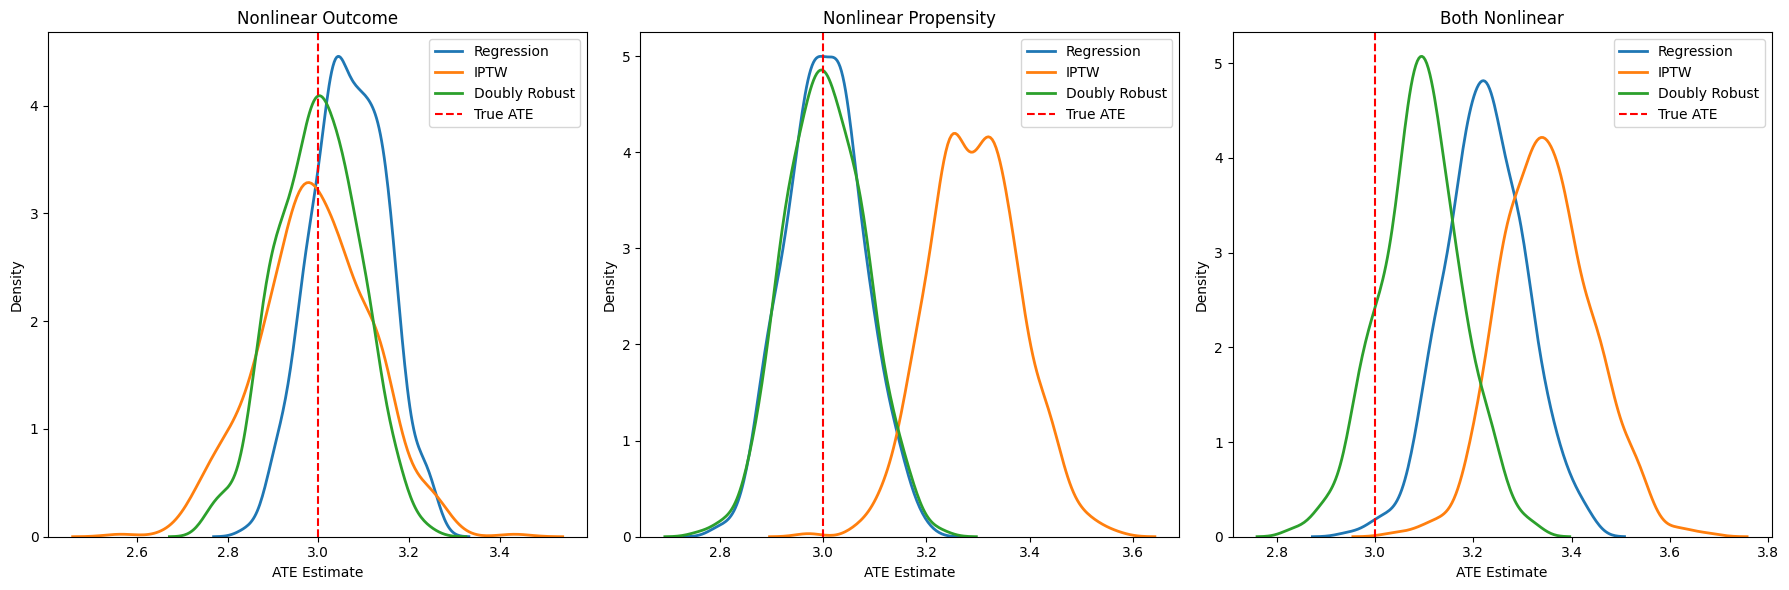

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

def regression_ate(df, X_col, T_col, Y_col):
    model = LinearRegression().fit(df[[T_col, X_col]], df[Y_col])
    return model.coef_[0]

def iptw_ate_func(df, X_col, T_col, Y_col):
    ps_model = LogisticRegression(max_iter=1000).fit(df[[X_col]], df[T_col])
    ps = ps_model.predict_proba(df[[X_col]])[:, 1]
    weights = np.where(df[T_col] == 1, 1 / ps, 1 / (1 - ps))
    return np.mean(weights * df[T_col] * df[Y_col]) - np.mean(weights * (1 - df[T_col]) * df[Y_col])

def doubly_robust_ate(df, X_col, T_col, Y_col):
    ps_model = LogisticRegression(max_iter=1000).fit(df[[X_col]], df[T_col])
    ps = ps_model.predict_proba(df[[X_col]])[:, 1]
    mu0_model = LinearRegression().fit(df[df[T_col] == 0][[X_col]], df[df[T_col] == 0][Y_col])
    mu1_model = LinearRegression().fit(df[df[T_col] == 1][[X_col]], df[df[T_col] == 1][Y_col])
    mu0 = mu0_model.predict(df[[X_col]])
    mu1 = mu1_model.predict(df[[X_col]])
    return (
        np.mean(df[T_col] * (df[Y_col] - mu1) / ps + mu1) -
        np.mean((1 - df[T_col]) * (df[Y_col] - mu0) / (1 - ps) + mu0)
)

n_simulations = 500
n = 1000
true_ate = 3
results_mc = {"Case": [], "Estimator": [], "ATE": []}

for sim in range(n_simulations):
    X = np.random.normal(0, 1, n)
    T1 = np.random.binomial(1, 1 / (1 + np.exp(-X)))
    Y1 = 2 + true_ate * T1 + np.sin(2 * X) + np.random.normal(0, 1, n)
    data1 = pd.DataFrame({'X': X, 'T': T1, 'Y': Y1})
    T2 = np.random.binomial(1, 1 / (1 + np.exp(-X - X**2)))
    Y2 = 2 + true_ate * T2 + 1.5 * X + np.random.normal(0, 1, n)
    data2 = pd.DataFrame({'X': X, 'T': T2, 'Y': Y2})
    T3 = np.random.binomial(1, 1 / (1 + np.exp(-X - X**2)))
    Y3 = 2 + true_ate * T3 + np.sin(2 * X) + np.random.normal(0, 1, n)
    data3 = pd.DataFrame({'X': X, 'T': T3, 'Y': Y3})
    for data, case in [(data1, "Nonlinear Outcome"),
                       (data2, "Nonlinear Propensity"),
                       (data3, "Both Nonlinear")]:
        reg_ate = regression_ate(data, 'X', 'T', 'Y')
        iptw_ate = iptw_ate_func(data, 'X', 'T', 'Y')
        dr_ate = doubly_robust_ate(data, 'X', 'T', 'Y')
        results_mc["Case"].extend([case] * 3)
        results_mc["Estimator"].extend(["Regression", "IPTW", "Doubly Robust"])
        results_mc["ATE"].extend([reg_ate, iptw_ate, dr_ate])

results_mc_df = pd.DataFrame(results_mc)

plt.figure(figsize=(18, 6))
cases = ["Nonlinear Outcome", "Nonlinear Propensity", "Both Nonlinear"]
estimators = ["Regression", "IPTW", "Doubly Robust"]

for i, case in enumerate(cases):
    plt.subplot(1, 3, i + 1)
    for estimator in estimators:
        subset = results_mc_df[(results_mc_df["Case"] == case) & (results_mc_df["Estimator"] == estimator)]
        sns.kdeplot(subset["ATE"], label=estimator, linewidth=2)
    plt.axvline(true_ate, color='red', linestyle='--', label='True ATE')
    plt.title(f"{case}")
    plt.xlabel("ATE Estimate")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()
